<a href="https://colab.research.google.com/github/Shahwaiz9/CodSoft/blob/main/CNNFYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import zipfile
import os

# Path to the zip file on Google Drive
zip_path = '/content/drive/MyDrive/FypDataSetPlantVillage/Tomato.zip'

# Directory to unzip the dataset
unzip_dir = '/content/dataset'

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print("Dataset unzipped successfully!")


Dataset unzipped successfully!


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler

Found 10 disease categories in the dataset directory.
Folder 'Tomato_Early_blight' contains 1000 images.
Folder 'Tomato_Spider_mites_Two_spotted_spider_mite' contains 1676 images.
Folder 'Tomato_Late_blight' contains 1909 images.
Folder 'Tomato_healthy' contains 1591 images.
Folder 'Tomato_Septoria_leaf_spot' contains 1771 images.
Folder 'Tomato__Tomato_YellowLeaf__Curl_Virus' contains 3209 images.
Folder 'Tomato__Tomato_mosaic_virus' contains 373 images.
Folder 'Tomato_Leaf_Mold' contains 952 images.
Folder 'Tomato_Bacterial_spot' contains 2127 images.
Folder 'Tomato__Target_Spot' contains 1404 images.
Found 9611 images belonging to 10 classes.
Found 6400 images belonging to 10 classes.
Found 6400 images belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


301/301 ━━━━━━━━━━━━━━━━━━━━ 100s 301ms/step - accuracy: 0.2242 - loss: 2.1167 - val_accuracy: 0.4317 - val_loss: 1.4617 - learning_rate: 0.0010
Epoch 2/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 120s 252ms/step - accuracy: 0.5414 - loss: 1.3279 - val_accuracy: 0.7056 - val_loss: 0.8597 - learning_rate: 0.0010
Epoch 3/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 81s 250ms/step - accuracy: 0.6626 - loss: 0.9928 - val_accuracy: 0.6903 - val_loss: 0.8512 - learning_rate: 0.0010
Epoch 4/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 89s 294ms/step - accuracy: 0.7116 - loss: 0.8260 - val_accuracy: 0.8125 - val_loss: 0.5487 - learning_rate: 0.0010
Epoch 5/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 130s 254ms/step - accuracy: 0.7400 - loss: 0.7493 - val_accuracy: 0.7242 - val_loss: 0.7596 - learning_rate: 0.0010
Epoch 6/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 76s 249ms/step - accuracy: 0.7722 - loss: 0.6410 - val_accuracy: 0.8602 - val_loss: 0.4046 - learning_rate: 0.0010
Epoch 7/20
301/301 ━━━━━━━━━━━━━━━━━━━━ 78s 256ms/step - accuracy: 0.7985 - lo

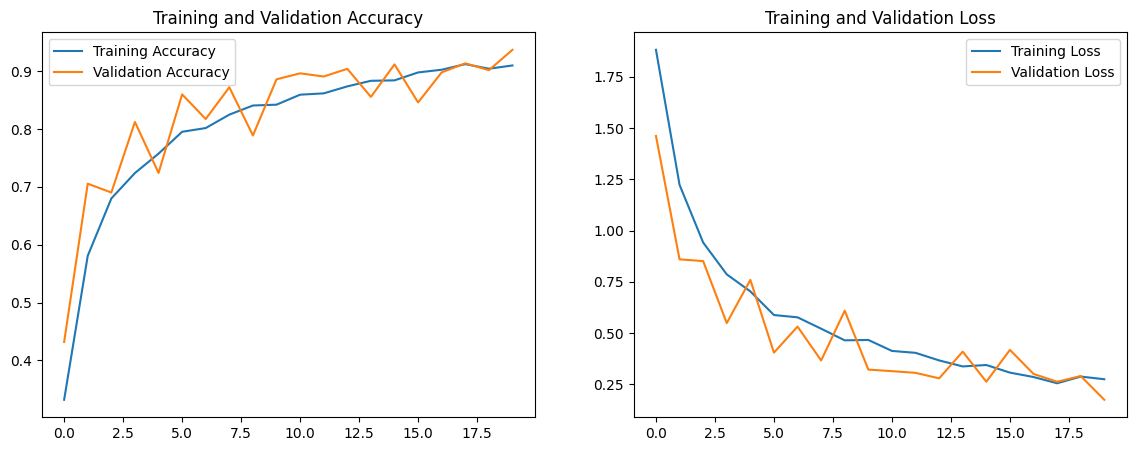

In [4]:

# Path to the dataset directory
data_dir = '/content/dataset/Tomato/'

# Check the number of subfolders in the Tomato directory (i.e., different disease categories)
subfolders = os.listdir(dataset_dir)
print(f"Found {len(subfolders)} disease categories in the dataset directory.")

# Check if each subfolder contains images
for subfolder in subfolders:
    subfolder_path = os.path.join(dataset_dir, subfolder)
    if os.path.isdir(subfolder_path):
        images_in_subfolder = len(os.listdir(subfolder_path))
        print(f"Folder '{subfolder}' contains {images_in_subfolder} images.")


# Image data generator for data augmentation and loading data with class imbalance handling
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.4,  # 20% validation, 20% test
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Load training, validation, and test sets
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

test_data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False  # No shuffling for test set
)

# Compute class weights for handling class imbalance
class_labels = list(train_data.class_indices.keys())
class_weights = compute_class_weight(
    'balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weights = dict(enumerate(class_weights))

# CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(len(class_labels), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
history = model.fit(
    train_data,
    epochs=20,
    validation_data=val_data,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

# Evaluate on test set
test_data.reset()
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Get true and predicted labels for F1 score and classification report
test_data.reset()
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=-1)

# Calculate accuracy and F1-score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Test Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 176ms/step
Total number of misclassified images: 353


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


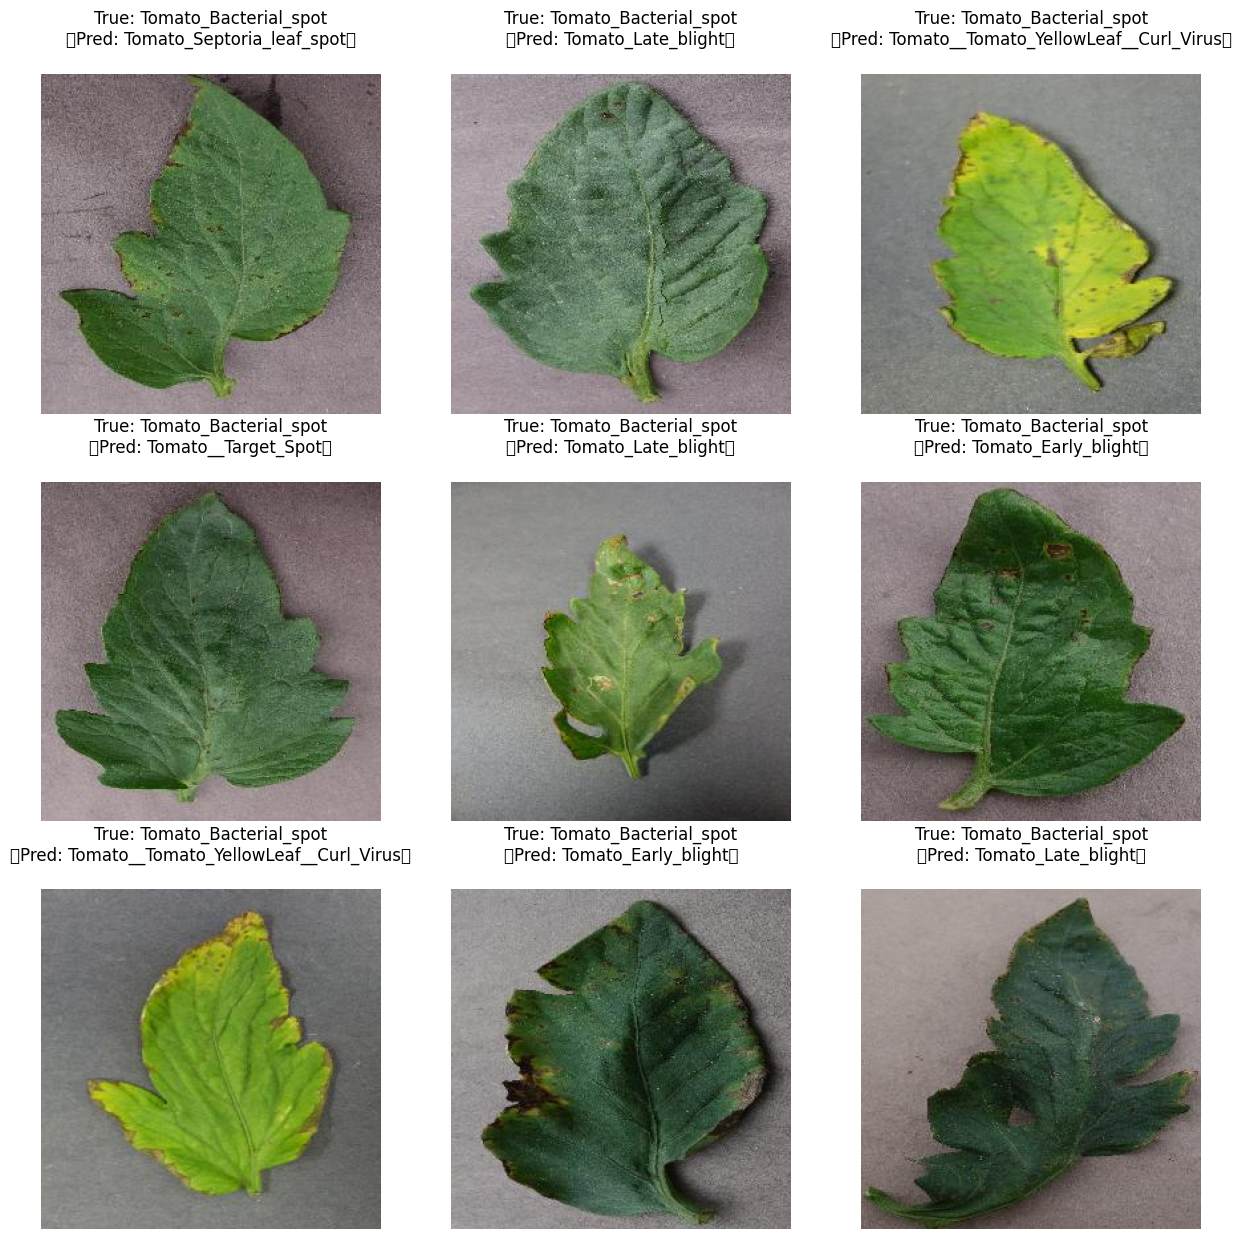

In [5]:
# Predict labels for the test dataset using test_generator
y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = test_data.classes  # True labels from the generator

# Get the filenames of misclassified images
misclassified_indices = np.where(y_true != y_pred)[0]
misclassified_filenames = np.array(test_data.filepaths)[misclassified_indices]
# Total number of misclassified images
total_misclassified = len(misclassified_indices)
print(f"Total number of misclassified images: {total_misclassified}")
# Display misclassified images
num_images = 9  # Number of misclassified images to display
plt.figure(figsize=(15, 15))


for i, idx in enumerate(misclassified_indices[:num_images]):
    # Load image
    img = plt.imread(misclassified_filenames[i])

    # Plot image
    plt.subplot(3, 3, i + 1)  # Adjust layout as needed
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {list(test_data.class_indices.keys())[y_true[idx]]}\n\tPred: {list(test_data.class_indices.keys())[y_pred[idx]]}\t\n")

plt.show()


Saving mold.png to mold (3).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicted Label: Tomato_Early_blight


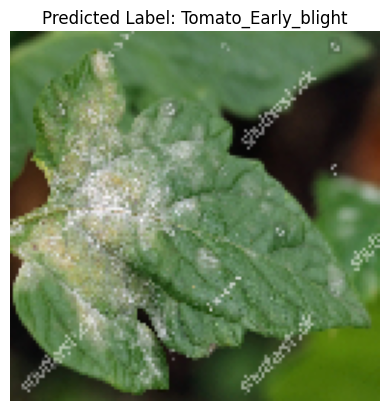

In [43]:
from google.colab import files
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Upload image(s) from your machine
uploaded = files.upload()

# Get the filename from the uploaded dictionary (assuming only one file is uploaded)
img_path = list(uploaded.keys())[0]

# Load and preprocess the image (resize, rescale)
img = image.load_img(img_path, target_size=(128, 128))  # Resize to match the model input size
img_array = image.img_to_array(img)  # Convert image to numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Apply rescaling as done during training

# Predict the label
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]  # Get the index of the highest probability

# Map the predicted index to the class label
class_indices = train_data.class_indices  # Assuming you have `train_data` from training
class_labels = {v: k for k, v in class_indices.items()}  # Invert the dictionary to map indices to labels
predicted_label = class_labels[predicted_class]

# Print the prediction
print(f"Predicted Label: {predicted_label}")

# Display the image
plt.imshow(img)
plt.title(f"Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()
